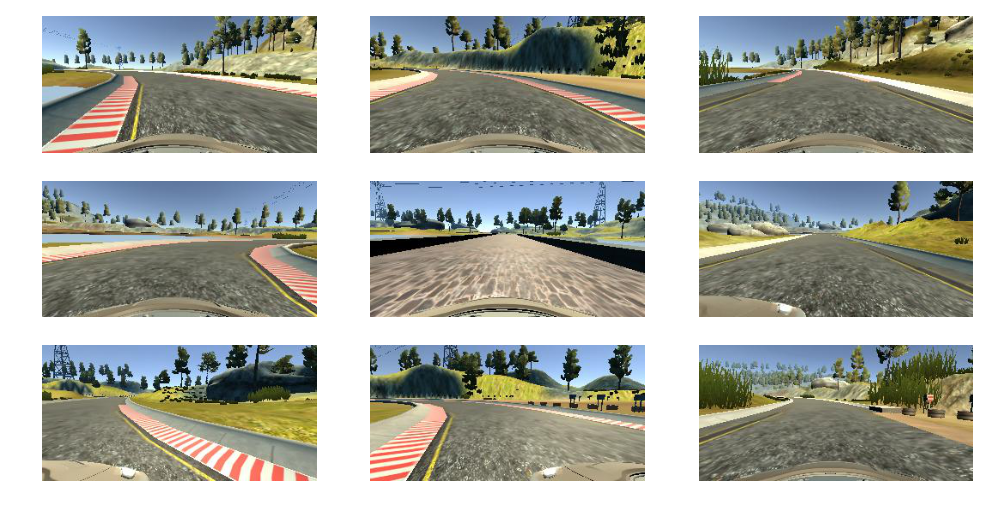

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualizations will be shown inline
%matplotlib inline

sample_data_directory = 'sample_images/'

S = np.ones((9,160,320,3), dtype=np.uint8)

plt.rcParams['figure.figsize'] = (12, 6)

for i in range(9):
    image = mpimg.imread(sample_data_directory + "sample_%d.jpg" % i)
    S[i] = image
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

# Observations 1

1. The bonnet of the car is visible at the bottom of the image, we can remove it during pre-processing.
2. The portion of the image above the horizon (where the road ends) can be ignored. Only the edges of the road and its curvature are relevant for determing the steering angle

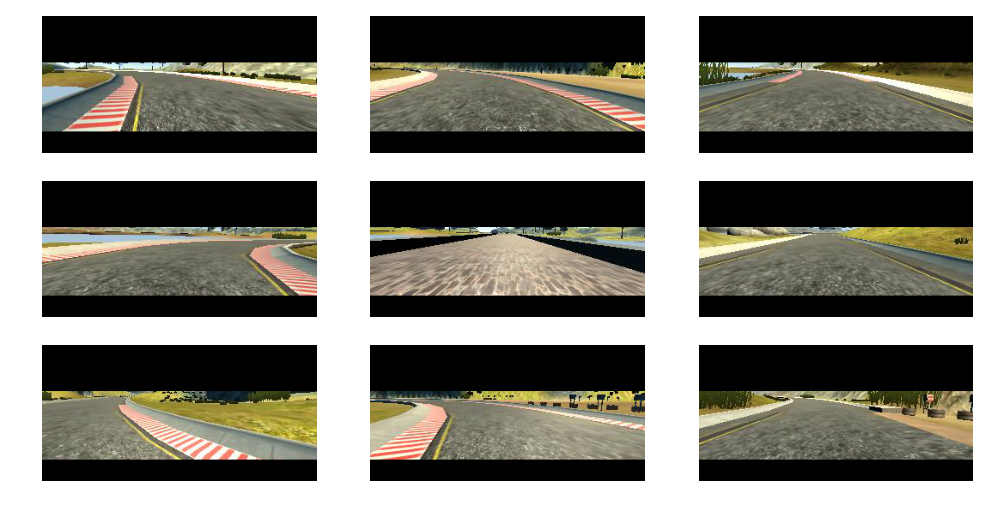

In [2]:
# Lets try shaving off the bonnet of the car and the portion above the horizon (where the road ends)

bottom_shave_pixels = 25
top_shave_pixels = 55

bonnet_pixels_start = 160 - bottom_shave_pixels
for i in range(9):
    S[i,bonnet_pixels_start:,:,:] = 0
    S[i,:top_shave_pixels,:,:] = 0
    image = S[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

# Observations 2

1. Shaving off 25 pixels from the bottom and 55 pixels from the top should work.
2. This will reduce the number of pixels by **half**!

**Note**: When I do preprocessing I will remove these pixels and resize the image. For the sake of simplicity and demonstration, I have just made these pixels zero.

# Explore driving_log.csv

Now lets explore the Udacity's diriving_log.csv

In [3]:
import pandas as pd

data_frame = pd.read_csv('udacity_data/driving_log.csv', usecols=[0,1,2,3])

data_frame.describe(include='all')

,center,left,right,steering
count,8036,8036,8036,8036.000000
unique,8036,8036,8036,NaN
top,IMG/center_2016_12_01_13_42_27_591.jpg,IMG/left_2016_12_01_13_33_42_278.jpg,IMG/right_2016_12_01_13_36_24_064.jpg,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,0.004070
std,NaN,NaN,NaN,0.128840
min,NaN,NaN,NaN,-0.942695
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1103f8390>]], dtype=object)

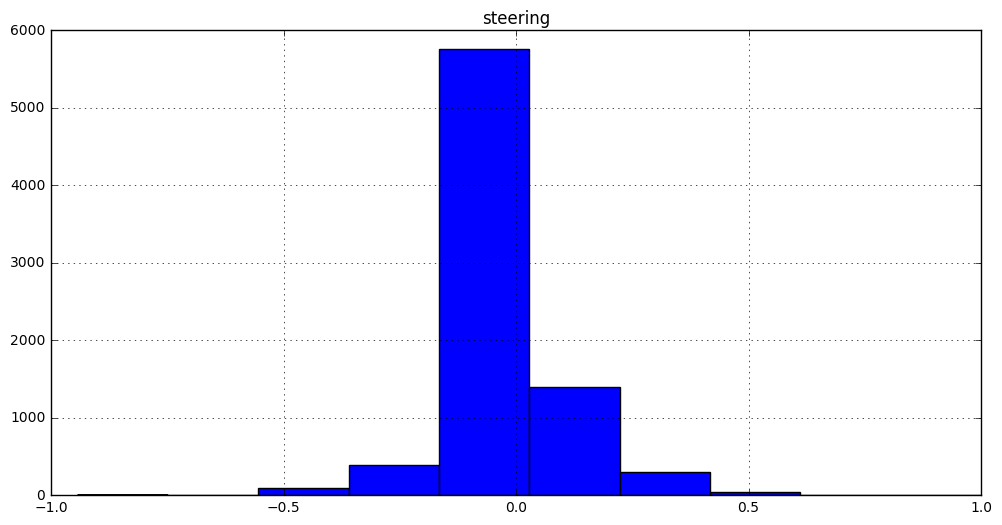

In [4]:
data_frame.hist(column='steering')

Using TensorFlow backend.


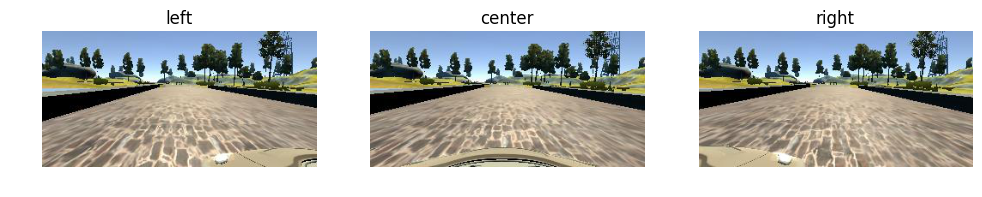

In [5]:
from keras.preprocessing.image import img_to_array, load_img

i = 0
for camera in ['left', 'center', 'right']:
    image = load_img("udacity_data/"+data_frame.iloc[0][camera].strip())
    image = img_to_array(image).astype(np.uint8)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera)
    i += 1

# Observations 3
1. The data set contains 8037 rows.
2. Most of the steering angles are close to zero, on the negative side.
3. The left and right cameras point straight, along the length of the car. So the left and right camera are like parallel transformations of the car.

# Conclusions:

1. The size of the image can be reduced by half by ignoring the non-usefull portions of the image.
2. The images can be flipped horizontally (and invert the corresponding steering angle), so that we can reduce the bias for turing left.
2. We can incorporate the left & right camera images to simulate recovery, when the steering anlge is close to zero.

# Augmentation Techniques

I have to thank the [NVIDEA paper](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and [this blog post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.d779iwp28) for suggesting these techniques.

## Use left & right camera images to simulate recovery
Using left and right camera images to simulate the effect of car wandering off to the side, and recovering. We will add a small angle .25 to the left camera and subtract a small angle of 0.25 from the right camera. The main idea being the left camera has to move right to get to center, and right camera has to move left.

## Flip the images horizontally
Since the dataset has a lot more images with the car turning left than right(because there are more left turns in the track), you can flip the image horizontally to simulate turing right and also reverse the corressponding steering angle.

## Brightness Adjustment
In this you adjust the brightness of the image to simulate driving in different lighting conditions

## Add Random Shadows
Although not demonstrated in the notebook, you can see an illustration of this method in [the above mentioned blog post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.d779iwp28).

With these augmentation techniques, you can practically generate infinite unique images for training your neural network.

In [6]:
import cv2

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

TARGET_SIZE = (64,64)

# def resize_to_target_size(image):
#     return cv2.resize(image, TARGET_SIZE) 
    
# def crop_and_resize(image):
#     cropped_image = image[55:135,:,:]
#     processed_image = resize_to_target_size(cropped_image)
#     return processed_image

def flip_image(image):
    return cv2.flip(image, 1)

def preprocess_image(image):
    image = crop_and_resize(image)
    image = image.astype(np.float32)
    image = image/255.0 - 0.5
    return image

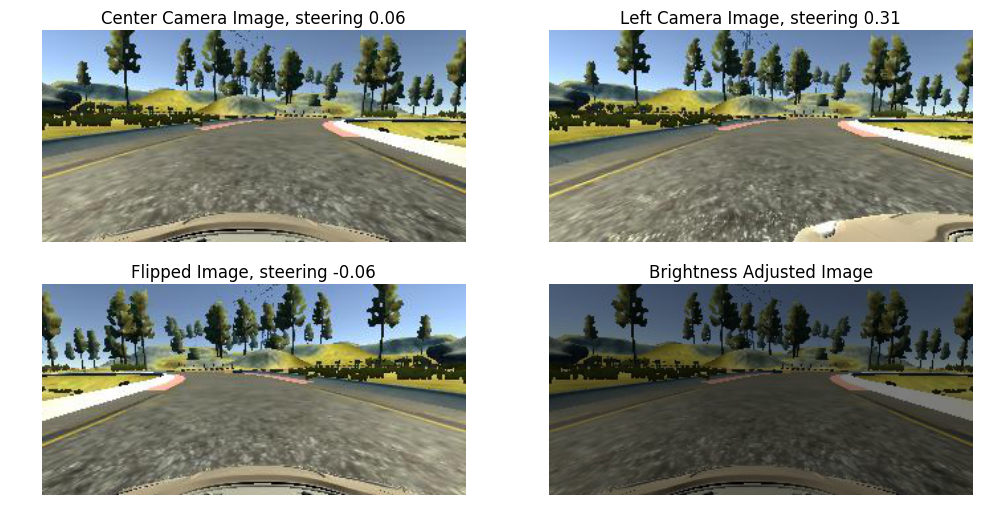

In [14]:
row = data_frame.iloc[2500]
steering = row['steering']
image = load_img("udacity_data/"+row["center"].strip())
image = img_to_array(image).astype(np.uint8)

plt.subplot(2,2,1)
plt.imshow(image, aspect='auto')
plt.axis('off')
plt.title("Center Camera Image, steering %.2f" % steering)

left = load_img("udacity_data/"+row["left"].strip())
left = img_to_array(left).astype(np.uint8)

plt.subplot(2,2,2)
plt.imshow(left, aspect='auto')
plt.axis('off')
plt.title("Left Camera Image, steering %.2f" % (steering + 0.25))

plt.subplot(2,2,3)
plt.imshow(flip_image(image), aspect='auto')
plt.axis('off')
plt.title("Flipped Image, steering %.2f" % (-1.0*steering))

plt.subplot(2,2,4)
plt.imshow(augment_brightness_camera_images(image), aspect='auto')
plt.axis('off')
plt.title("Brightness Adjusted Image")